In [1]:
from experiments.mlp import MLPExperiment
from layers.hebbian_layer import HebbianLayer
from models.hebbian_network import HebbianNetwork
import torch
import os

In [2]:
experiment=MLPExperiment(None, 784, 64 , 10, lamb=5, num_epochs=1, K=1000, heb_lr=0.1)
experiment.train()

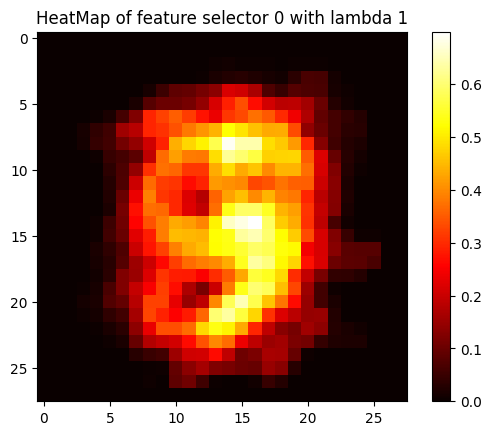

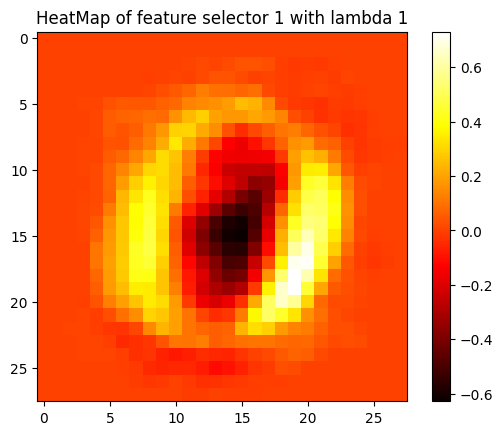

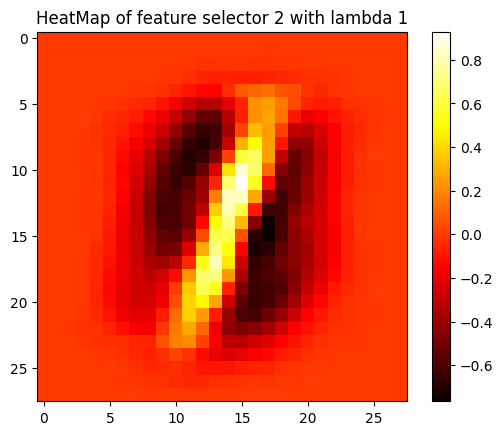

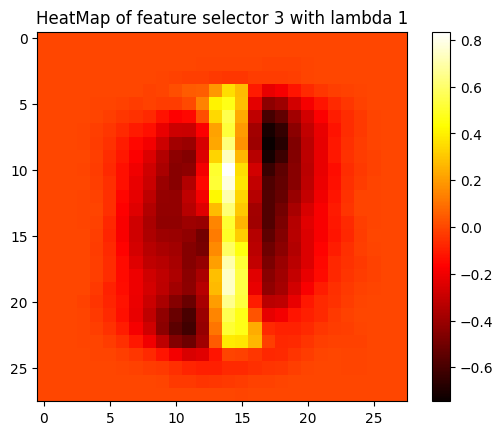

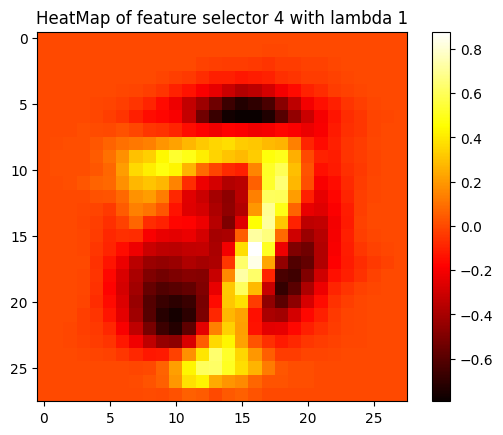

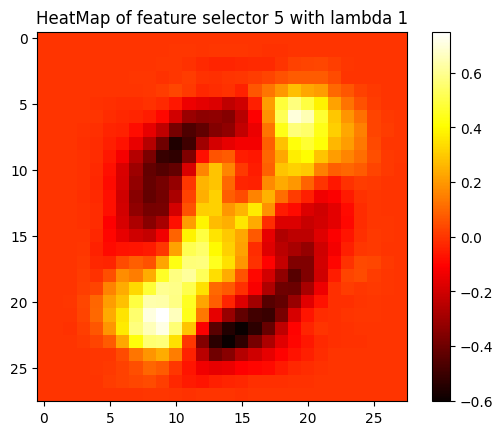

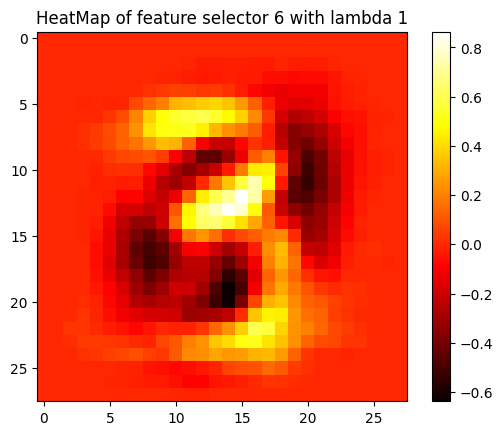

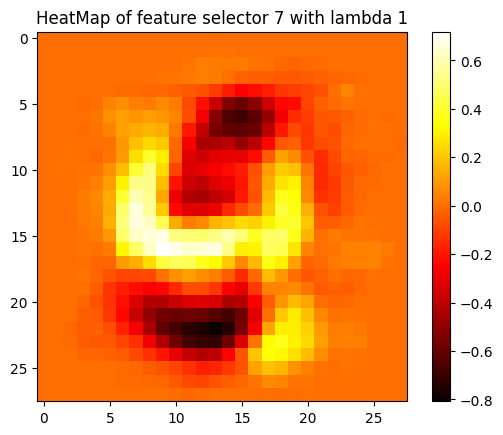

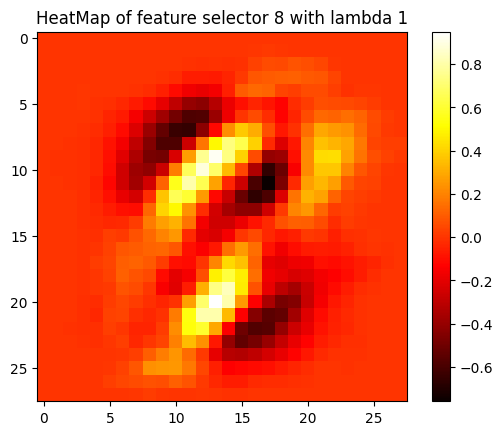

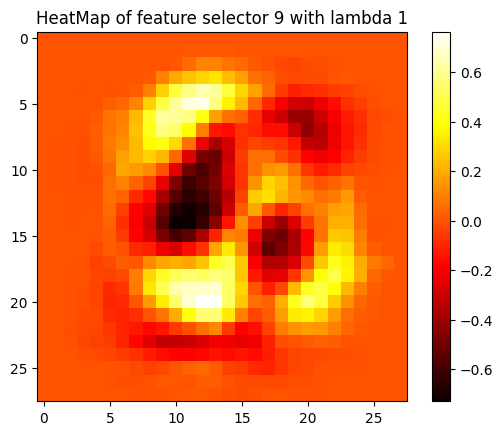

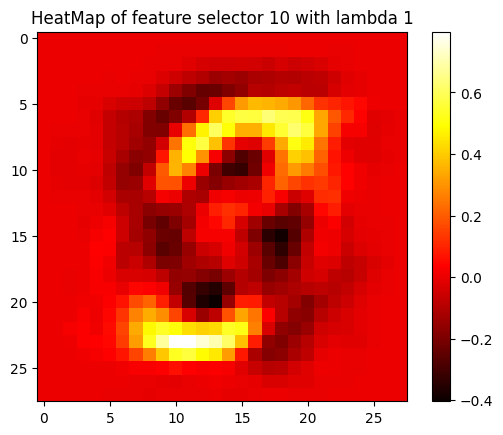

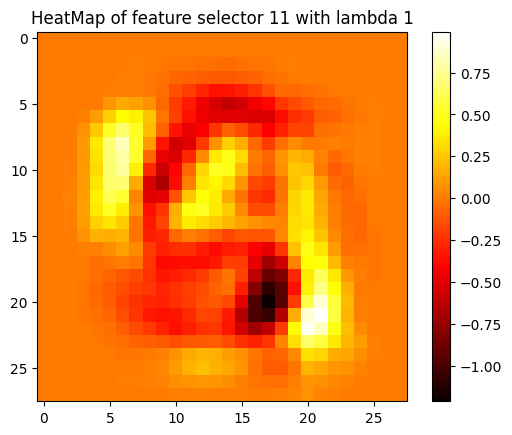

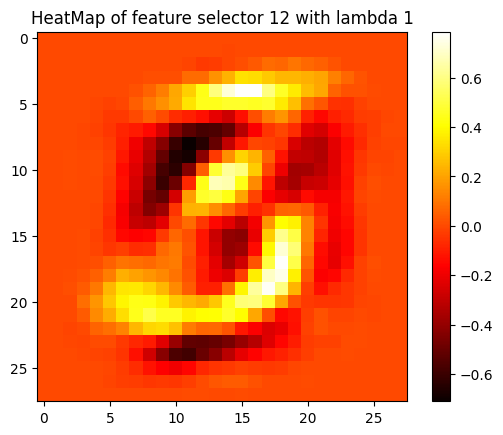

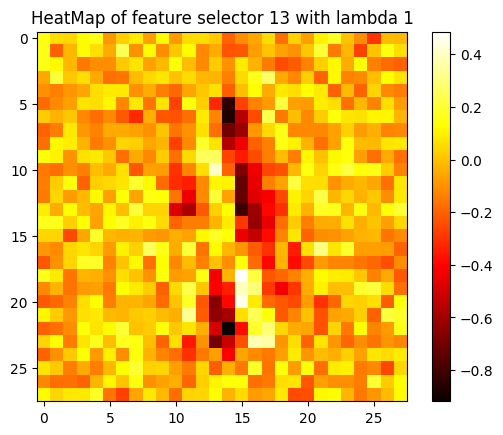

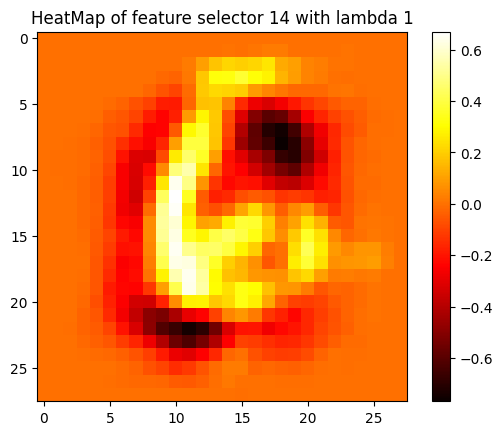

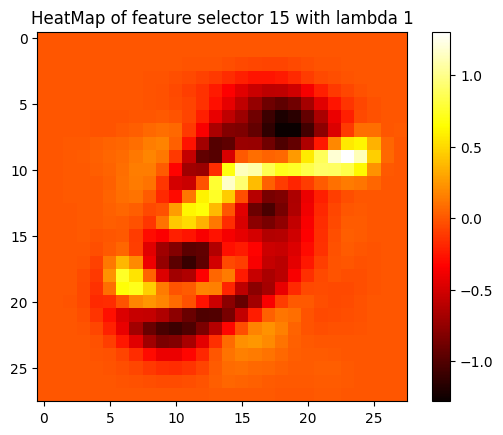

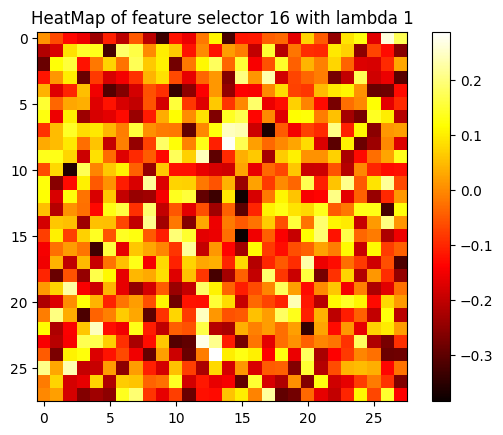

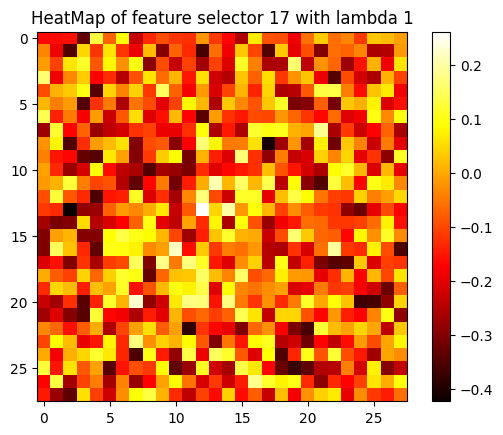

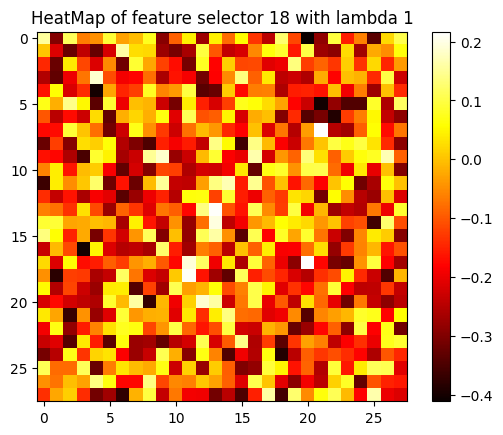

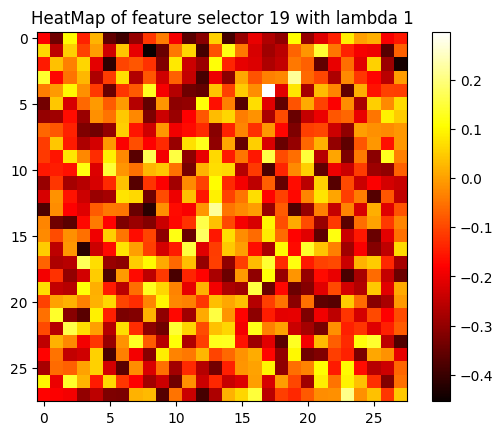

In [3]:
experiment.visualizeWeights(10, classifier=0)